# Problem Understanding: Garbage Classification

The Garbage Classification Dataset contains 6 classifications: cardboard (393), glass (491), metal (400), paper(584), plastic (472) and trash(127).

The data can be downloaded from [kaggle](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification)

# Setup

In [1]:
import os 
import glob
import random
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import bentoml

# set a fixed random state to produce the same results
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

/home/frauke/anaconda3/envs/streamlit_deploy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read the Data



In [2]:
data_path = "../../pytorch-introduction/data/garbage"

## Some Random example Plots

In [3]:
def plot_examples(data_path, split='train'):
    # subfolders of species
    subfolders = [x[0] for x in os.walk(os.path.join(os.path.join(data_path, f'{split}')), f'{split}')][1:]
    
    folder = []
    # select random folder
    for i in range(15):
        folder.append(random.choice(subfolders))
    
    imgs = []
    for f in folder:
        images = glob.glob(f"{f}/*.jpg")
        img_path = random.choice(images)
        imgs.append(mpimg.imread(img_path))
        
    fig, axes = plt.subplots(3, 5, figsize=(20,12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i])
        ax.set_title(folder[i].split('/')[-1])
        ax.set_xticks([])
        ax.set_yticks([]);

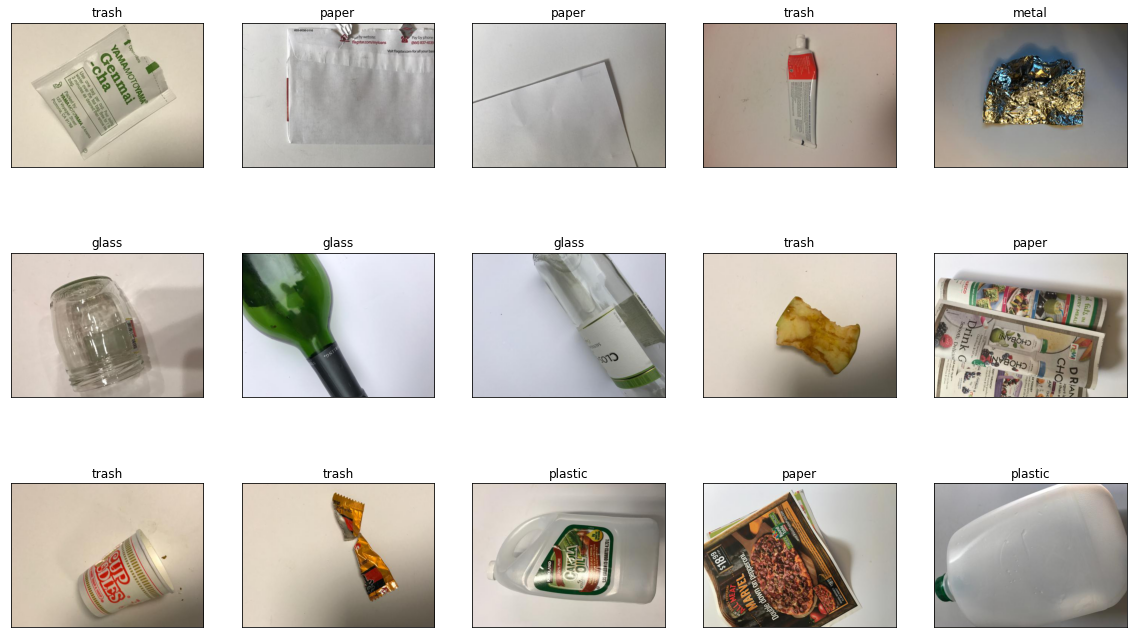

In [4]:
plot_examples(data_path, split='train')

In [5]:
img = mpimg.imread(os.path.join(data_path, 'train/paper/paper99.jpg'))
img.shape

(384, 512, 3)

# Data Preparation

We will use PyTorch ```ImageFolder``` to create the dataset. This is ... to creata datasets from image data. In order to use it, the training, validation and test data need to be stored in specific folders with the following structure.

https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

train

-class 1 
-class 2
...
-class n

valid

-class 1
-class 2
...
-class n

test

-class 1
-class 2
...
-class n 

use glog.glob to get all images and select random images for train, valid, test!!

In [6]:
img_size = 224

In [7]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((img_size, img_size)),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                       ])
valid_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((img_size, img_size)),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((img_size, img_size)),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])

datadir_train = "../../pytorch-introduction/data/garbage/train"
datadir_valid = "../../pytorch-introduction/data/garbage/valid"
datadir_test = "../../pytorch-introduction/data/garbage/test"

train_data = datasets.ImageFolder(datadir_train,       
                    transform=train_transforms)
valid_data = datasets.ImageFolder(datadir_valid,
                    transform=valid_transforms)
test_data = datasets.ImageFolder(datadir_test,
                    transform=test_transforms)

In [8]:
train_data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [9]:
valid_data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [10]:
test_data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

## Plot Class Distribution

In [11]:
classes = train_data.classes
train_imgs = {}
valid_imgs = {}
test_imgs = {}
for class_ in classes:
    train_imgs[class_] = len(glob.glob(os.path.join(data_path, f'train/{class_}/*')))
    valid_imgs[class_] = len(glob.glob(os.path.join(data_path, f'valid/{class_}/*')))
    test_imgs[class_] = len(glob.glob(os.path.join(data_path, f'test/{class_}/*')))
print(f'training data: {train_imgs}')
print(f'validation data: {valid_imgs}')
print(f'test data: {test_imgs}')

training data: {'cardboard': 241, 'glass': 300, 'metal': 246, 'paper': 356, 'plastic': 289, 'trash': 82}
validation data: {'cardboard': 80, 'glass': 100, 'metal': 82, 'paper': 118, 'plastic': 96, 'trash': 27}
test data: {'cardboard': 80, 'glass': 100, 'metal': 82, 'paper': 118, 'plastic': 96, 'trash': 27}


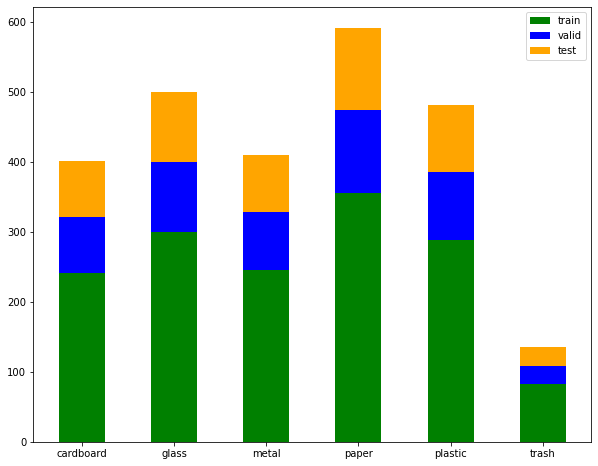

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(train_imgs.keys(), train_imgs.values(), width=0.5, color='g', label='train')
ax.bar(valid_imgs.keys(), valid_imgs.values(), width=0.5, color='b', label='valid', bottom=list(train_imgs.values()))
ax.bar(test_imgs.keys(), test_imgs.values(), width=0.5, color='orange', label='test', bottom=np.array(list(train_imgs.values()))+np.array(list(valid_imgs.values())))
ax.legend();

# Define Training and Validation Loops

ADD tqdm!!

In [13]:
def train(model, device, train_dataloader, optimizer, criteriom, epoch, print_every):
    '''
    parameters:
    model - the model used for training
    device - the device we work on (cpu or gpu)
    train_dataloader - the training data wrapped in a dataloader
    optimizer - the optimizer used for optimizing the parameters
    criterion - loss function
    epoch - current epoch
    print_every - integer after how many batches results should be printed
    '''
    
    # create empty list to store the train losses
    train_loss = []
    # variable to count correct classified samples
    correct = 0
    # variable to count true positive, false positive and false negative samples
    TP = 0
    FP = 0
    FN = 0
    # create an empty list to store the predictions
    predictions = []

    # set model to training mode, i.e. the model is used for training
    # this effects layers like BatchNorm() and Dropout
    # in our simple example we don't use these layers
    # for the sake of completeness 'model.train()' is included 
    model.train()

    # loop over batches
    for batch_idx, (x, y) in enumerate(train_dataloader):
        
        # set data to device
        x, y = x.to(device), y.to(device)

        # set optimizer to zero
        optimizer.zero_grad()

        # apply model
        y_hat = model(x.float())
            
        # calculate loss
        loss = criterion(y_hat, y.long())
        train_loss.append(loss.item())

        # backpropagation
        loss.backward()
        
        # update the weights
        optimizer.step()
        
        # print the loss every x batches
        if batch_idx % print_every == 0:
            percent = 100. * batch_idx / len(train_dataloader)
            print(f'Train Epoch {epoch} \
            [{batch_idx * len(train_dataloader)}/{len(train_dataloader.dataset)} \
            ({percent:.0f}%)] \tLoss: {loss.item():.6f}')

        # to get the predictions, we need to find the index with the highest predicted propability
        y_pred = y_hat.argmax(dim=-1, keepdims=True)
        predictions.append(y_pred)
        correct += y_pred.eq(y.view_as(y_pred)).sum().item() 
        TP += torch.logical_and(y_pred == 1, y == 1).sum()
        FP += torch.logical_and(y_pred == 1, y == 0).sum()
        FN += torch.logical_and(y_pred == 0, y == 1).sum()

    # total training loss over all batches
    train_loss = torch.mean(torch.tensor(train_loss))
    epoch_accuracy = correct/len(train_dataloader.dataset)
    # recall = TP/(TP+FN)
    epoch_recall = TP/(TP+FN)
    # precision = TP/(TP+FP)
    epoch_precision = TP/(TP+FP)

    return epoch_accuracy, train_loss, epoch_recall, epoch_precision

In [14]:
def valid(model, device, val_dataloader, criterion):
    '''
    parameters:
    model - the model used for training
    device - the device we work on (cpu or gpu)
    val_dataloader - the validation data wrapped in a dataloader
    criterion - loss function
    '''
    
    # create an empty list to store the loss
    val_loss = []
    # variable to count correct classified samples
    correct = 0
    # variable to count true positive, false positive and false negative samples
    TP = 0
    FP = 0
    FN = 0
    # create an empty list to store the predictions
    predictions = []

    # set model to evaluation mode, i.e. 
    # the model is only used for inference, this has effects on
    # dropout-layers, which are ignored in this mode and batchnorm-layers, which use running statistics
    model.eval()

    # disable gradient calculation 
    # this is useful for inference, when we are sure that we will not call Tensor.backward(). 
    # It will reduce memory consumption for computations that would otherwise have requires_grad=True.
    with torch.no_grad():
        # loop over batches
        for x, y in val_dataloader:
            
            # set data to device
            x, y = x.to(device), y.to(device)

            # apply model
            y_hat = model(x.float())
            
            # append current loss
            loss = criterion(y_hat, y.long())
            val_loss.append(loss.item())

            # to get the predictions, we need to find the index with the highest predicted propability
            y_pred = y_hat.argmax(dim=-1, keepdims=True)
            predictions.append(y_pred)
            correct += y_pred.eq(y.view_as(y_pred)).sum().item() #(y_pred == y).sum().item()
            TP += torch.logical_and(y_pred == 1, y == 1).sum()
            FP += torch.logical_and(y_pred == 1, y == 0).sum()
            FN += torch.logical_and(y_pred == 0, y == 1).sum()
            
        # total validation loss over all batches
        val_loss = torch.mean(torch.tensor(val_loss))
        epoch_accuracy = correct/len(val_dataloader.dataset)
        # recall = TP/(TP+FN)
        epoch_recall = TP/(TP+FN)
        # precision = TP/(TP+FP)
        epoch_precision = TP/(TP+FP)
        
        print(f'Validation: Average loss: {val_loss.item():.4f}, \
                Accuracy: {epoch_accuracy:.4f} \
               ({100. * correct/len(val_dataloader.dataset):.0f}%)')
        
    return predictions, epoch_accuracy, val_loss, epoch_recall, epoch_precision

# Set the Hyperparameters

In [15]:
# hyperparameters
batch_size = 32
epochs = 5
learning_rate = 0.001

print_every = 100

# Load the Data

In [16]:
train_dataloader = torch.utils.data.DataLoader(train_data,
                   shuffle=True, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(valid_data,
                   shuffle=False, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data,
                   shuffle=False, batch_size=batch_size)

In [17]:
print(f'image dataloader item: {next(iter(train_dataloader))[0].shape}')
print(f'label dataloader length of item: {len(next(iter(train_dataloader))[1])}')

image dataloader item: torch.Size([32, 3, 224, 224])
label dataloader length of item: 32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


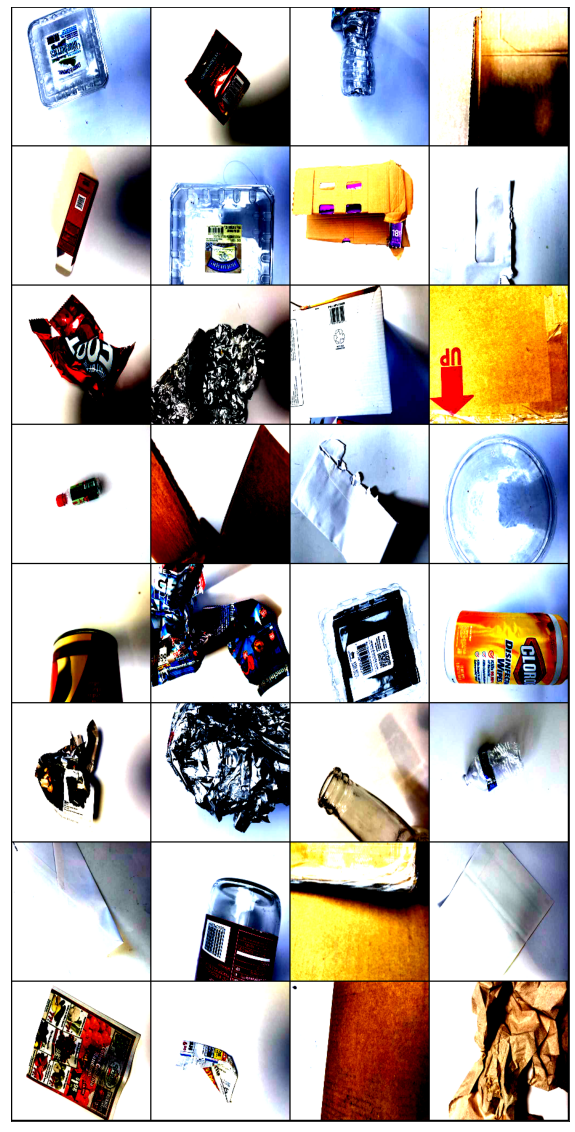

In [18]:
# Visualize one training batch
for images, labels in train_dataloader:
    fig, ax = plt.subplots(figsize = (10, 25))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

# Define a custom Model

* Introduce new layer types: Conv2D, MaxPool2D, Dropout
* flatten after convolution -> later different approach!! or reference!!
* Explain how to get dimensions for flatten
* explain why no softmax activation at the end:
    * keep in mind that CrossEntropyLoss does a softmax for you. (It’s actually a LogSoftmax + NLLLoss combined into one function, see CrossEntropyLoss: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [19]:
#https://www.kaggle.com/code/raymondchoy/machine-vision-cnn-2-code
#model = Sequential([
#    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)),
#    MaxPooling2D(pool_size=2),
#    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
#    MaxPooling2D(pool_size=2),
#    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
#    MaxPooling2D(pool_size=2),
#    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
#    MaxPooling2D(pool_size=2),
#    Flatten(),
#    Dense(64, activation='relu'),
#    Dense(6, activation='softmax')
#])

In [20]:
class GarbageClassifier(nn.Module):
    def __init__(self, img_size):
        super().__init__()
    
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 32, 3) # input channels, output, kernel size
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
    
        # pooling layer
        self.pool = nn.MaxPool2d(2, 2)
    
        # dropout layer
        self.drop = nn.Dropout(0.2)
        
        # linear layer
        a = 128 * 26 * 26
        self.fc1 = nn.Linear(a, 128)
        self.fc2 = nn.Linear(128, 6) # 6 classes
    
        # activation layer
        self.relu = nn.ReLU()
    
    def forward(self, x):
    
        # convolutional part
        x = self.conv1(x)
        #print(x.shape)
        x = self.relu(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)

        x = self.conv2(x)
        #print(x.shape)
        x = self.relu(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        
        x = self.conv3(x)
        #print(x.shape)
        x = self.relu(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        
        x = self.drop(x)
        
        # flatten x to pass it through the linear layer
        # (batch_size, 128, 26, 26) are the shape after applying the convolutional layer 
        # note, that this hard coded way is not very flexible, we will later see a
        # more flexible approach to achieve this number 
        a = 128 * 26 * 26
        x = x.view(-1, a)
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [21]:
next(iter(train_dataloader))[0][0].size()

torch.Size([3, 224, 224])

In [22]:
model = GarbageClassifier(img_size)
out = model(next(iter(train_dataloader))[0])
print(out.shape)
out

torch.Size([32, 6])


tensor([[ 7.5909e-02, -1.2536e-01, -4.7184e-02,  9.7242e-02,  2.4858e-02,
         -5.6509e-02],
        [ 7.7015e-02, -1.0665e-01,  1.4065e-02,  8.7276e-02,  1.5025e-02,
         -4.3370e-02],
        [ 9.8781e-02, -8.1236e-02, -2.5795e-03,  7.4189e-02,  2.4572e-02,
         -5.0868e-02],
        [ 8.9576e-02, -8.0608e-02, -3.0228e-02,  8.7514e-02,  1.1745e-02,
         -7.5123e-02],
        [ 7.1921e-02, -1.1172e-01,  1.8042e-02,  4.3551e-02,  1.0335e-02,
         -5.8587e-02],
        [ 5.4076e-02, -7.9931e-02, -2.9374e-04,  6.4567e-02,  6.2082e-03,
         -2.5651e-02],
        [ 9.3098e-02, -1.1099e-01, -2.8695e-02,  8.5155e-02,  3.2915e-02,
         -6.9889e-02],
        [ 3.9539e-02, -9.2066e-02, -7.7080e-03,  4.4191e-02,  9.0166e-03,
         -3.0175e-02],
        [ 9.2632e-02, -1.3331e-01, -8.3714e-02,  8.5331e-02,  8.0851e-03,
         -8.8911e-02],
        [ 8.4702e-02, -1.0615e-01, -1.2298e-02,  6.4792e-02,  6.9751e-03,
         -7.1297e-02],
        [ 8.7872e-02, -1.0402e

# Train the custom Model

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = GarbageClassifier(img_size).to(device)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# define loss 
criterion = nn.CrossEntropyLoss()

cpu


In [24]:
# create empty lists to store the accuracy and loss per validation epoch 
train_epoch_accuracy = []
train_epoch_loss = []
train_epoch_recall = []
train_epoch_precision = []
val_epoch_accuracy = []
val_epoch_loss = []
val_epoch_recall = []
val_epoch_precision = []

# loop over number of epochs
for epoch in range(epochs):
    
    # train model for each epoch
    train_accuracy, train_loss, train_recall, train_precision = \
        train(model, device, train_dataloader, optimizer, criterion, epoch, print_every)
    # save training loss and accuracy for each epoch
    train_epoch_accuracy.append(train_accuracy)
    train_epoch_loss.append(train_loss)
    train_epoch_recall.append(train_recall)
    train_epoch_precision.append(train_precision)
    
    # validate model for each epoch
    predictions, val_accuracy, val_loss, val_recall, val_precision = \
        valid(model, device, val_dataloader, criterion)
    # save validation loss and accuracy for each epoch
    val_epoch_accuracy.append(val_accuracy)
    val_epoch_loss.append(val_loss)
    val_epoch_recall.append(val_recall)
    val_epoch_precision.append(val_precision)

Train Epoch 0             [0/1514             (0%)] 	Loss: 1.803632
Validation: Average loss: 1.4078,                 Accuracy: 0.4215                (42%)
Train Epoch 1             [0/1514             (0%)] 	Loss: 1.365003
Validation: Average loss: 1.1502,                 Accuracy: 0.5706                (57%)
Train Epoch 2             [0/1514             (0%)] 	Loss: 0.992529
Validation: Average loss: 0.9646,                 Accuracy: 0.6720                (67%)
Train Epoch 3             [0/1514             (0%)] 	Loss: 0.772755
Validation: Average loss: 0.8774,                 Accuracy: 0.7038                (70%)
Train Epoch 4             [0/1514             (0%)] 	Loss: 0.676068
Validation: Average loss: 0.8254,                 Accuracy: 0.7078                (71%)


# Evaluate the Results

To evaluate the results we will plot the loss and the accuracy.

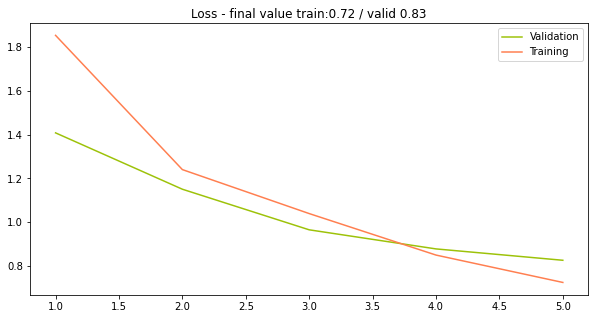

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(1, epochs+1)
ax.plot(x, val_epoch_loss, label="Validation", color="#9DC209")
ax.plot(x, train_epoch_loss, label="Training", color="#FF7F50")
ax.legend()
ax.set_title(f"Loss - final value train:{train_epoch_loss[-1]:.2} / valid {val_epoch_loss[-1]:.2}");

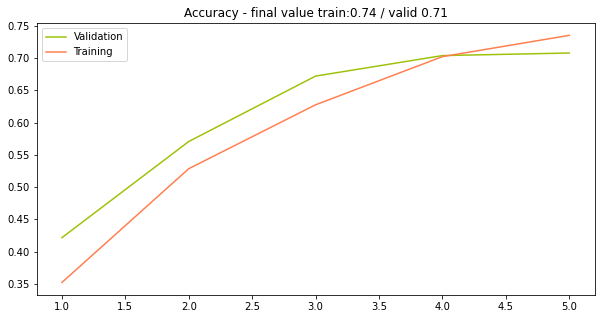

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(1, epochs+1)
ax.plot(x, val_epoch_accuracy, label="Validation", color="#9DC209")
ax.plot(x, train_epoch_accuracy, label="Training", color="#FF7F50")
ax.legend()
ax.set_title(f"Accuracy - final value train:{train_epoch_accuracy[-1]:.2} / valid {val_epoch_accuracy[-1]:.2}");

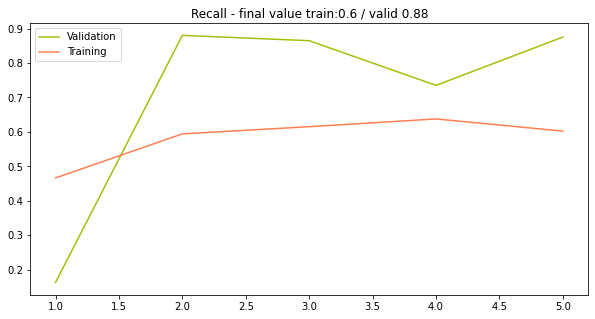

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(1, epochs+1)
ax.plot(x, val_epoch_recall, label="Validation", color="#9DC209")
ax.plot(x, train_epoch_recall, label="Training", color="#FF7F50")
ax.legend()
ax.set_title(f"Recall - final value train:{train_epoch_recall[-1]:.2} / valid {val_epoch_recall[-1]:.2}");

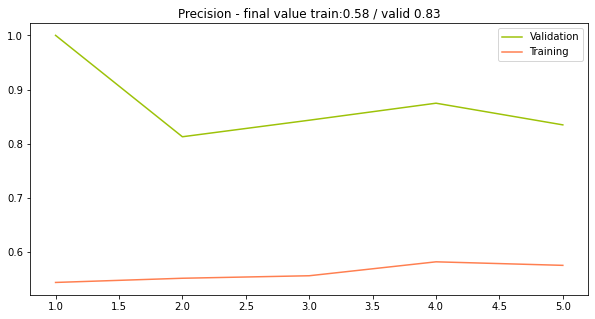

In [28]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(1, epochs+1)
ax.plot(x, val_epoch_precision, label="Validation", color="#9DC209")
ax.plot(x, train_epoch_precision, label="Training", color="#FF7F50")
ax.legend()
ax.set_title(f"Precision - final value train:{train_epoch_precision[-1]:.2} / valid {val_epoch_precision[-1]:.2}");

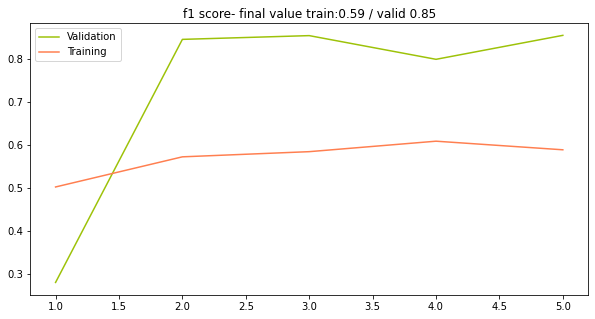

In [29]:
f1_val = 2*(np.array(val_epoch_precision)*np.array(val_epoch_recall))/(np.array(val_epoch_precision)+np.array(val_epoch_recall))
f1_train = 2*(np.array(train_epoch_precision)*np.array(train_epoch_recall))/(np.array(train_epoch_precision)+np.array(train_epoch_recall))

fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(1, epochs+1)
ax.plot(x, f1_val , label="Validation", color="#9DC209")
ax.plot(x, f1_train, label="Training", color="#FF7F50")
ax.legend()
ax.set_title(f"f1 score- final value train:{f1_train[-1]:.2} / valid {f1_val[-1]:.2}");

# Save the Model¶

In [30]:
torch.save(model.state_dict(), 'garbage_model_weights.pth')

# Load the Model
Note: be sure to call model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.

In [31]:
model = GarbageClassifier(img_size)
model.load_state_dict(torch.load('garbage_model_weights.pth'))
model.eval()

GarbageClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=86528, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
  (relu): ReLU()
)

# Apply to Test Set

The test data has already been prepared and a dataloader created. We can now apply the valid function we defined above for one epoch.

In [32]:
predictions, test_accuracy, test_loss, test_recall, test_precision = \
        valid(model, device, val_dataloader, criterion)
# save validation loss and accuracy for each epoch
print()
print(f"Accuracy on test set {test_accuracy:.4f}")
print(f"Loss on test set {test_loss.item():.4f}")
print(f"Recall on test set {test_recall.item():.4f}")
print(f"Precision on test set {test_precision.item():.4f}")

Validation: Average loss: 0.8254,                 Accuracy: 0.7078                (71%)

Accuracy on test set 0.7078
Loss on test set 0.8254
Recall on test set 0.8752
Precision on test set 0.8347


## Some Example Plots on the Test Set
Visualize the model's results with some example plots from the validation set.

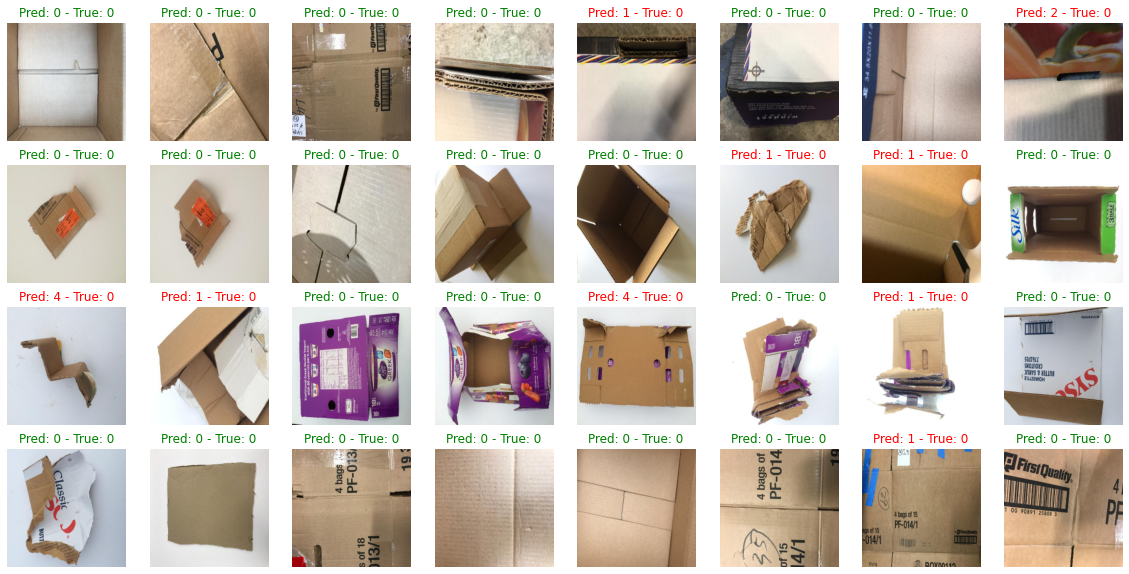

In [33]:
# first batch of validation data
X_test = next(iter(test_dataloader))[0]
y_test = next(iter(test_dataloader))[1]

fig, axes = plt.subplots(4,8, figsize=(20,10))
    
for i, ax in enumerate(axes.flatten()):
    img = X_test[i].permute(1,2,0)
    img = img*torch.tensor([0.229, 0.224, 0.225])+torch.tensor([0.485, 0.456, 0.406])
    ax.imshow((img))
    ax.axis('off')
    ax.set_title(f'Pred: {predictions[0][i].item()} - True: {int(y_test[i].item())}',
                color=("green" if predictions[0][i]==y_test[i] else "red"))

# Make Predictions

Download some images according to the classes and save them in ```data/garbage/extra/```. Apply the Model to these images. The images used in this notebook are provided ... !!!

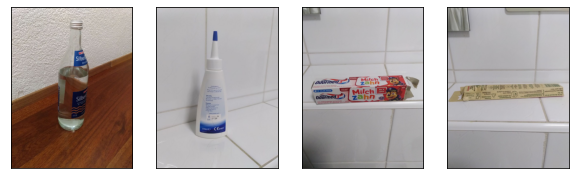

In [34]:
# data path
extra_path = '../../pytorch-introduction/data/garbage/extra'
images = ['img1.jpeg', 'img2.jpeg', 'img3.jpeg', 'img4.jpeg']

# load image
fig, axes = plt.subplots(1, 4, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    img = mpimg.imread(os.path.join(extra_path, images[i]))
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([]);

In [35]:
def predict_image(image):
    image_tensor = test_transforms(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [36]:
y_pred = []
for img in images:
    img = mpimg.imread(os.path.join(extra_path, img))
    y_pred.append(predict_image(img))

/home/frauke/anaconda3/envs/streamlit_deploy/lib/python3.9/site-packages/torchvision/transforms/functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642881969/work/torch/csrc/utils/tensor_numpy.cpp:199.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [37]:
y_pred

[0, 4, 4, 1]

In [38]:
train_data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Use a pretrained Model

In [39]:
GarbageClassifierVGG16 = models.vgg16(pretrained = True)

/home/frauke/anaconda3/envs/streamlit_deploy/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/frauke/anaconda3/envs/streamlit_deploy/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
# Freeze model weights
for param in GarbageClassifierVGG16.parameters():
    param.requires_grad = False

In [41]:
GarbageClassifierVGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [42]:
# change the classifier
GarbageClassifierVGG16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),#inplace=True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048),
    nn.ReLU(),#inplace=True),
    nn.Dropout(0.4),
    nn.Linear(2048, 6)
)

In [43]:
GarbageClassifierVGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Train the pretrained Model

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = GarbageClassifierVGG16.to(device)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# define loss 
criterion = nn.CrossEntropyLoss()

cpu


In contrast to previous examples, save the model during training and validation loop, if the loss is decreasing.

In [ ]:
# create empty lists to store the accuracy and loss per validation epoch 
train_epoch_accuracy = []
train_epoch_loss = []
train_epoch_recall = []
train_epoch_precision = []
val_epoch_accuracy = []
val_epoch_loss = []
val_epoch_recall = []
val_epoch_precision = []
min_loss = 9999

# loop over number of epochs
for epoch in range(epochs):
    
    # train model for each epoch
    train_accuracy, train_loss, train_recall, train_precision = \
        train(model, device, train_dataloader, optimizer, criterion, epoch, print_every)
    # save training loss and accuracy for each epoch
    train_epoch_accuracy.append(train_accuracy)
    train_epoch_loss.append(train_loss)
    train_epoch_recall.append(train_recall)
    train_epoch_precision.append(train_precision)
    
    # validate model for each epoch
    predictions, val_accuracy, val_loss, val_recall, val_precision = \
        valid(model, device, val_dataloader, criterion)
    # save validation loss and accuracy for each epoch
    val_epoch_accuracy.append(val_accuracy)
    val_epoch_loss.append(val_loss)
    val_epoch_recall.append(val_recall)
    val_epoch_precision.append(val_precision)
    
    # save model if loss is decreasing
    if val_loss < min_loss:
        min_loss = val_loss
        #torch.save({
        #    'epoch': epoch,
        #    'model_state_dict': model.state_dict(),
        #    'optimizer_state_dict': optimizer.state_dict(),
        #    'loss': val_loss,
        #    }, f'{model.__class__.__name__}_epoch={epoch:02d}_acc={val_epoch_accuracy:.3f}.pt')
        torch.save(model.state_dict(), f'{model.__class__.__name__}_epoch={epoch:02d}_acc={val_accuracy:.3f}.pth')
        print("model saved")
        bentoml.pytorch.save_model("garbage_classification", model)
        print("model saved to bentoml")

Train Epoch 0             [0/1514             (0%)] 	Loss: 0.143576
Validation: Average loss: 0.4017,                 Accuracy: 0.9046                (90%)
model saved
model saved to bentoml
Train Epoch 1             [0/1514             (0%)] 	Loss: 0.084154
Validation: Average loss: 0.6689,                 Accuracy: 0.9085                (91%)
Train Epoch 2             [0/1514             (0%)] 	Loss: 0.052249


# Evaluate the Results

To evaluate the results we will plot the loss and the accuracy.

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(1, epochs+1)
ax.plot(x, val_epoch_loss, label="Validation", color="#9DC209")
ax.plot(x, train_epoch_loss, label="Training", color="#FF7F50")
ax.legend()
ax.set_title(f"Loss - final value train:{train_epoch_loss[-1]:.2} / valid {val_epoch_loss[-1]:.2}");

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(1, epochs+1)
ax.plot(x, val_epoch_accuracy, label="Validation", color="#9DC209")
ax.plot(x, train_epoch_accuracy, label="Training", color="#FF7F50")
ax.legend()
ax.set_title(f"Accuracy - final value train:{train_epoch_accuracy[-1]:.2} / valid {val_epoch_accuracy[-1]:.2}");

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(1, epochs+1)
ax.plot(x, val_epoch_recall, label="Validation", color="#9DC209")
ax.plot(x, train_epoch_recall, label="Training", color="#FF7F50")
ax.legend()
ax.set_title(f"Recall - final value train:{train_epoch_recall[-1]:.2} / valid {val_epoch_recall[-1]:.2}");

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(1, epochs+1)
ax.plot(x, val_epoch_precision, label="Validation", color="#9DC209")
ax.plot(x, train_epoch_precision, label="Training", color="#FF7F50")
ax.legend()
ax.set_title(f"Precision - final value train:{train_epoch_precision[-1]:.2} / valid {val_epoch_precision[-1]:.2}");

In [ ]:
f1_val = 2*(np.array(val_epoch_precision)*np.array(val_epoch_recall))/(np.array(val_epoch_precision)+np.array(val_epoch_recall))
f1_train = 2*(np.array(train_epoch_precision)*np.array(train_epoch_recall))/(np.array(train_epoch_precision)+np.array(train_epoch_recall))

fig, ax = plt.subplots(1,1, figsize=(10,5))
x = np.arange(1, epochs+1)
ax.plot(x, f1_val , label="Validation", color="#9DC209")
ax.plot(x, f1_train, label="Training", color="#FF7F50")
ax.legend()
ax.set_title(f"f1 score- final value train:{f1_train[-1]:.2} / valid {f1_val[-1]:.2}");

# Load the Model

In [ ]:
model = GarbageClassifierVGG16.to(device)
model.load_state_dict(torch.load('VGG_epoch=00_acc=0.930.pth'))
model.eval()

# Apply to Test Set

The test data has already been prepared and a dataloader created. We can now apply the valid function we defined above for one epoch.

In [ ]:
predictions, test_accuracy, test_loss, test_recall, test_precision = \
        valid(model, device, val_dataloader, criterion)
# save validation loss and accuracy for each epoch
print()
print(f"Accuracy on test set {test_accuracy:.4f}")
print(f"Loss on test set {test_loss.item():.4f}")
print(f"Recall on test set {test_recall.item():.4f}")
print(f"Precision on test set {test_precision.item():.4f}")

## Some Example Plots on the Test Set
Visualize the model's results with some example plots from the validation set.

In [ ]:
# first batch of validation data
X_test = next(iter(test_dataloader))[0]
y_test = next(iter(test_dataloader))[1]

fig, axes = plt.subplots(4,8, figsize=(20,10))
    
for i, ax in enumerate(axes.flatten()):
    img = X_test[i].permute(1,2,0)
    img = img*torch.tensor([0.229, 0.224, 0.225])+torch.tensor([0.485, 0.456, 0.406])
    ax.imshow((img))
    ax.axis('off')
    ax.set_title(f'Pred: {predictions[0][i].item()} - True: {int(y_test[i].item())}',
                color=("green" if predictions[0][i]==y_test[i] else "red"))

# Make Predictions

Download some images according to the classes and save them in ```data/garbage/extra/```. Apply the Model to these images. The images used in this notebook are provided ... !!!

In [ ]:
# data path
extra_path = 'data/garbage/extra'
images = ['img1.jpeg', 'img2.jpeg', 'img3.jpeg', 'img4.jpeg']

# load image
fig, axes = plt.subplots(1, 4, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    img = mpimg.imread(os.path.join(extra_path, images[i]))
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([]);

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
y_pred = []
for img in images:
    img = mpimg.imread(os.path.join(extra_path, img))
    y_pred.append(predict_image(img))

In [ ]:
y_pred

In [ ]:
train_data.classes

## Load Model wit Bentoml

In [ ]:
model = bentoml.pytorch.load_runner("garbage_classification:latest")

# Load a sample image from memory
extra_path = '../../pytorch-introduction/data/garbage/extra'
images = ['img1.jpeg', 'img2.jpeg', 'img3.jpeg', 'img4.jpeg']
n = 
img = os.path.join(extra_path, images[n])

print(model.run(img))